Train RMSE: 125.80
Test RMSE: 309.59


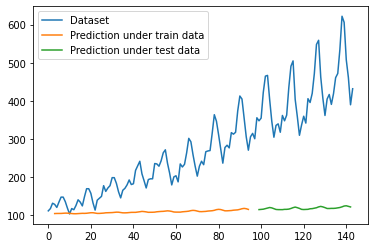

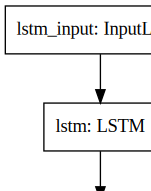

In [5]:

from tensorflow.python.keras.utils.vis_utils import model_to_dot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import SVG
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.models import Sequential
import numpy as np

%matplotlib inline


dataframe = pd.read_csv('data/international-airline-passengers.csv',
                        usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]


# X=[data[t-look_back],...,data[t-1]], Y=data[t]となるデータセットに変換

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]へ変形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


# LSTMにDenseを接続し、数値を予測（MSEで評価）
model = Sequential()

# input_shape=(系列長T, x_tの次元), output_shape=(units,)
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


# テストデータに対する予測（評価のため訓練データも）
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 正規化を元に戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 平均二乗誤差のルートで評価
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))


# 訓練データ部分の予測データ
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# テストデータ部分の予測データ
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2) +
                1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Prediction under train data')
plt.plot(testPredictPlot, label='Prediction under test data')
plt.legend()
plt.show()


SVG(model_to_dot(model).create(prog='dot', format='svg'))
